# This project implemented by Elham Mahdipour
## I am a Ph.D. Graduate  of computer engineering at Yazd University, Yazd, Iran.
## I am a Faculty Member of Computer Engineering Department at Khavaran Institute of Higher Education, Mashhad, Iran.
### Please feel free and contact to me: elham.mahdipour@gmail.com/ e.mahdipour@profs.khi.ac.ir

# Please run all cells for train the RENA model. This program train RENA tune model for EC-SC species.

# Phase 1 
## Create Dataset and Preprocessing

In [1]:
import networkx as nx
G1=nx.read_weighted_edgelist('large dataset\sc-sc.evals')
G1

In [2]:
G2=nx.read_weighted_edgelist('large dataset\ec-ec.evals')
G2

In [3]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

4265
6613


In [4]:
G_target_na=nx.read_weighted_edgelist('large dataset\ec-sc.evals')
G_target_na  

In [5]:
ed1=G1.edges()
ed2=G2.edges()

nd1=G1.nodes()
nd2=G2.nodes()

el1=list(ed1)
el2=list(ed2)

nd1=list(nd1)
nd2=list(nd2)

degG1 = [val for (node, val) in G1.degree()]
degG2 = [val for (node, val) in G2.degree()]

# Feature Extraction

# compute score for create similarity matrix

In [6]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [7]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [8]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [9]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node

In [10]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [11]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [12]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [13]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s,coeff_pr, dd, cd

In [14]:
import numpy as np
m, coeff_pr, dd, cd=compute_score(G1,G2)
sim=m

# Phase 2: Dataset Generation

# create data for deep learning

# change problem to classification 
## [node of G1, node of G2, Coefficient page rank, clustering coefficient difference,  similarity score, alignment=yes(0)/TN or no(1)/TP]

In [15]:
import numpy as np
int_nd1=np.zeros(len(nd1))
int_nd2=np.zeros(len(nd2))

species=['ec','sc','ce','dm','mm','hs']
ch1=0  #please set index for first species of species list, for example index of ec is 0
ch2=1  #please set index for second species of species list, for example index of sc is 1
# If don't set index with considering species may be given an error
for i in range(len(nd1)):
    if (species[ch1] in nd1[i] or species[ch2] in nd1[i]):
        s=nd1[i][2:]
        x=int(s)
        int_nd1[i]=x    
for i in range(len(nd2)):
    if (species[ch1] in nd2[i] or species[ch2] in nd2[i]):
        s=nd2[i][2:]
        x=int(s)
        int_nd2[i]=x    

In [16]:
# en_mat is encoding matrix
en_mat=[]

for i in range(len(nd1)):
    for j in range(len(nd2)):
        if G_target_na.has_edge(nd1[i],nd2[j]):
            align_class='Yes'
        else:
            align_class='No'
        
        sample=[int_nd1[i],int_nd2[j], coeff_pr[i][j], dd[i][j],cd[i][j],sim[i][j],align_class] 
        en_mat.append(sample)
print(len(en_mat))

28204445


In [17]:
yc=[]
noc=[]
for i in range(len(en_mat)):
    if en_mat[i][6]=='Yes':
        yc.append(en_mat[i])
    else:
        noc.append(en_mat[i])
print(len(yc), len(noc))

4561 28199884


In [18]:
from random import shuffle
noc.sort(key = lambda i: i[6])
data=yc+noc[0:len(yc)] 
shuffle(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:6])
    y.append(data[i][6])

len(X),len(y)

(9122, 9122)

In [36]:
data=yc+noc 
len(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:6])
    y.append(data[i][6])

len(X),len(y)

(28204445, 28204445)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [20]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

8209 8209 913 913


In [20]:
x_tr,y_tr,x_te,y_te=X_train, y_train,X_test,y_test

# test model for real data

In [20]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# One Hot Encode
y_train = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [22]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [23]:
import numpy as np
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [37]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [38]:
import numpy as np
X_test=np.array(X)
y_test=np.array(y_test)

# Phase 3: Architecture of RENA Network

# Train model with resample

In [44]:
from keras import Sequential
from keras.layers import Dense,SimpleRNN,Embedding
import keras

callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=1,),
keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]
#del model_rnn
model_rnn = Sequential()

model_rnn.add(layers.Embedding(6, 8))
model_rnn.add(layers.SimpleRNN(4))
model_rnn.add(Dense(2, activation='softmax'))
model_rnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_rnn.summary()
history_rnn = model_rnn.fit(X_train, y_train,epochs=1000,validation_split=0.2, callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           48        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________
Train on 6567 samples, validate on 1642 samples
Epoch 1/1000
6567/6567 [==============================] - 1s 162us/step - loss: 0.4548 - acc: 0.9510 - mae: 0.3603 - mse: 0.1361 - val_loss: 0.2756 - val_acc: 1.0000 - val_mae: 0.2407 - val_mse: 0.0582
Epoch 2/1000
6567/6567 [==============================] - 1s 127us/step - loss: 0.1907 - acc: 1.0000 - mae: 0.1727 - mse: 0.0314 - val_l

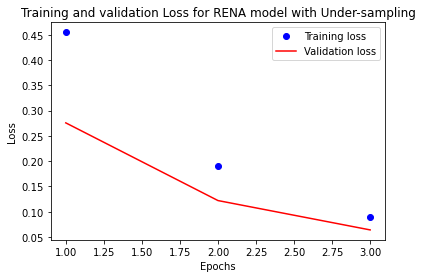

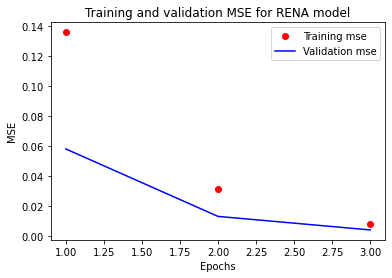

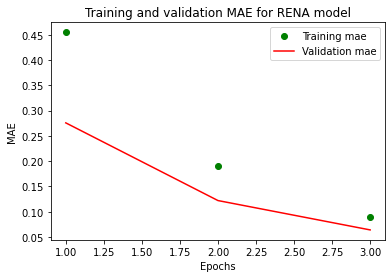

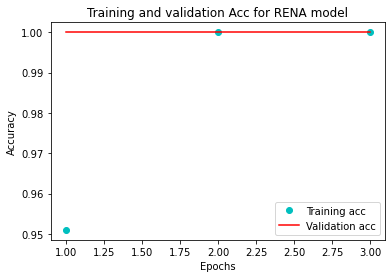

In [45]:
import matplotlib.pyplot as plt
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
mse = history_rnn.history['mse']
val_mse = history_rnn.history['val_mse']
mae = history_rnn.history['mae']
val_mae = history_rnn.history['val_mae']
acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss for RENA model with Under-sampling')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, mse, 'ro', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and validation MSE for RENA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training mae')
plt.plot(epochs, val_loss, 'r', label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and validation MAE for RENA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation Acc for RENA model')
plt.legend()
plt.show()

In [46]:
# save model
import h5py
model_rnn.save('large dataset/deep_model_resample_6features_undersampling-rnn_ec-sc.h5')
model_rnn.save_weights('large dataset/deep_model_resample_6features_undersampling-rnn_weights_ec-sc.h5')

# Test for real data

In [ ]:
from keras.models import load_model
model_rnn = load_model('large dataset/deep_model_resample_6features_undersampling-rnn_ec-sc.h5')
model_rnn.load_weights('large dataset/deep_model_resample_6features_undersampling-rnn_weights_ec-sc.h5')

In [47]:
results_te = model_rnn.evaluate(X_test, y_test)
results_te

28204445/28204445 [==============================] - 1602s 57us/step


[0.04416530668118989, 1.0, 0.04300079122185707, 0.001860475167632103]

In [48]:
%%time
output_te=model_rnn.predict(X_test)
print(output_te)

[[0.08107181 0.9189282 ]
 [0.08107181 0.9189282 ]
 [0.08107181 0.9189282 ]
 ...
 [0.95680326 0.04319674]
 [0.95680326 0.04319674]
 [0.95680326 0.04319674]]
Wall time: 14min 37s


In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), output_te.argmax(axis=1)))
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))

[[28199884        0]
 [       0     4561]]
1.0
1.0
1.0


# test other classifier without resample

In [78]:
x_tra,y_tra,x_tes,y_tes=X_train,y_train,X_test,y_test

In [79]:
X_train,y_train,X_test,y_test=x_tr,y_tr,x_te,y_te

In [89]:
%%time
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 1.00
Wall time: 2min 22s


In [90]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = lda.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999761660888749
[[25379886        0]
 [     605     3509]]
0.9999880813968492
0.9264705882352942
0.9603115009448575
Wall time: 3min 56s


In [91]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds = lda.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999726993435433
[[2819998       0]
 [     77     370]]
0.9999863478808187
0.9138702460850112
0.952869550836202
Wall time: 25.4 s


In [ ]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# time: one hour

In [5]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = knn.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999808934762054
[[25379886        0]
 [     485     3629]]
0.9999904453721342
0.9410549343704424
0.9686766122826788
Wall time: 20min 4s


In [6]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
# Make predictions
preds =  knn.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999709265736435
[[2819998       0]
 [     82     365]]
0.9999854614053503
0.9082774049217002
0.9495001197595498
Wall time: 2min 19s


In [7]:
%%time
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00
Wall time: 3h 29min 4s


In [8]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds_tr = svm.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99998262685156
[[25379886        0]
 [     441     3673]]
0.999991312168673
0.9464025279533301
0.9716792312360152
Wall time: 42min 41s


In [9]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds = svm.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999840450709019
[[2819998       0]
 [     45     402]]
0.9999920213982553
0.9496644295302014
0.973494243882846
Wall time: 4min 42s
Parser   : 1.64 s
